# Facial Ratings Analysis

## Introduction 
> what do you think of that guy? He's hot

> "Do I look good?"

Those are questions that most people have asked themselves or at least have heard people saying. Assessing the visual attractiveness of oneself and other people is an ubiquitous aspect of social interactions spanning many sides., has. Grounded in human psychology, attractiveness of people has observable effects on several facets of life, namely in dating but also in working life, and everyday interactions through the halo/horn effects. A major problem of the estimation of attractiveness is that unlike other features (such as height, weight , hair texture... ) there is no objective consensual way to quantitatively assess attractiveness of people since this evaluation is fundamentally subjective. As the saying goes "beauty is in the eye of the beholder"... Nevertheless stopping at that would be frustrating and simplistic : there are agreements between the way two individuals assess attractiveness. This tension rises several questions : 

- What does the distribution of facial ratings looks like? 
- Is there a difference in the way men and women rate faces ? What of their age ? What of their ethnic background ?
- Is there a difference in the way men and women are rated ? What of their age ? What of their ethnic background ?
- How to quantify the variation between the ratings of different individuals? How much do their rating differ ? Is this variation the same for men and women ?

In this analysis we will attempt to answer those questions using statistical analysis and a dataset of faces associated with attractiveness ratings. We focus specifically on facial ratings since attempting to analyse the rating of overall appearances would bring a tremendous amount of extra complexity both for analysing techniques (adding a lot of biases and removing reasonable assumptions) and to find a suitable dataset. In this analysis we focus in intra-individual ratings, since self-rating has already been extensively studied.

### Dataset

We use the [ME-beauty dataset](https://github.com/fbplab/MEBeauty-database), a dataset developed for facial beauty prediction. This dataset has many advantages : All face images are captured in an unconstrained environment and rated by volunteers with various ethnicity, age and gender in order to avoid any cultural and social biases in beauty perception. Besides the large number of raters (m=?) and number of rated faces (n= ?) gives us a . Here are some info on the dataset

We must underline that the following analysis makes conclusion based on this dataset and does not necessarily hold for the general population. Although we hope to make statements as generalisable as possible, we must keep in mind the possibility of the following facts :

- 
- The analysis is only made on static 2D pictures of people which limits the information available to the rater : only one pose, one angle . In real life, the facial rating s is made based on more complete data that includevarious angles and the extra dimension of temporality.
- The dataset has already been cleaned (outlier raters have been removed), 


## Preparing Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [2]:
link_data = "https://github.com/fbplab/MEBeauty-database/raw/main/scores/generic_scores_all_2022.xlsx"
df = pd.read_excel(link_data)

In [3]:
df.head() # Each row represents an image. Each column represents a rater

,mean,image,path,malecm39,femalecf41,femaleaf48,malehm23,femalecf34_2,femalecf34,femalecm17,...,AWLRHUE8GWXG4,AX7QB1F1M1IDO,AXKHNWMKGT751,AXMPSUNKUBEIL,AXMQBHHU22TSP,AY0758IITCGOZ,AY7RI824FORAE,AYBFVMPV70TDP,AYDHJW4ZG0D38,AZD9Z5B2U40G2
0,1.117647,kuma-kum-GKbPbR0ZAT4-unsplash.jpg,/home/ubuntu/ME-beautydatabase/images/female/c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.000000,pexels-cottonbro-5529905.jpg,/home/ubuntu/ME-beautydatabase/images/male/asi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.000000,pexels-nishant-aneja-2561432.jpg,/home/ubuntu/ME-beautydatabase/images/male/ind...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.428571,woman-1929550_1920.jpg,NaN,1.0,1.0,2.0,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.500000,pexels-himesh-mehta-3059930.jpg,/home/ubuntu/ME-beautydatabase/images/female/i...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Each row represents an image.

The columns represent :
- 0 : the mean of the rating for the image
- 1 : the image (we won't be using this row since we are only interesting in the ratings)
- 2 : the path to the image in the original repository (the path contains information on the gender and ethnical background of the person in the picture)
- from 3 to 362 , an individual rater. Thus Each cell is the rating of one rater for an image.

We extract the information about gender and ethnicity of the person in the image from the path.

Note that the names of the 10 first individual raters contain information on the rater. But this is only the case for the 11 first raters out of a total of 360. We won't be able to meaningfully exploit this data. Let's rename each rater as rater_{i} with i being the index of the rater.


In [4]:
def extract_gender_ethnicity(row):
    try :
        path = Path(row["path"])
        gender, ethnicity = path.parts[-3: -1]
    except TypeError:
        gender, ethnicity = None, None
    return gender, ethnicity

df[['gender', 'ethnicity']] = df.apply(extract_gender_ethnicity, axis=1, result_type="expand")

# Create a dictionary to map old column names to new column names (rater_i)
new_column_names = {old_col: f"rater_{i+1}" for i, old_col in enumerate(df.columns[3:363])}

# Rename the columns using the dictionary
df = df.rename(columns=new_column_names)


df = df.drop(["image", "path"], axis=1) #We then remove the columns we don't need anymore
df = df.rename(columns={"mean":"mean_rating"})


In [5]:
# Let's set aside the individual ratings for now. We will use them later
complete_df = df
df = df.iloc[:, [0, -2, -1]]

complete_df.head()

,mean_rating,rater_1,rater_2,rater_3,rater_4,rater_5,rater_6,rater_7,rater_8,rater_9,...,rater_353,rater_354,rater_355,rater_356,rater_357,rater_358,rater_359,rater_360,gender,ethnicity
0,1.117647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female,caucasian
1,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male,asian
2,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male,indian
3,1.428571,1.0,1.0,2.0,1.0,NaN,1.0,NaN,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
4,1.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female,indian


In [6]:
df.head()

,mean_rating,gender,ethnicity
0,1.117647,female,caucasian
1,1.000000,male,asian
2,1.000000,male,indian
3,1.428571,None,None
4,1.500000,female,indian


## Exploration of mean ratings
First let's have a look at the distribution of the mean rating of each image.

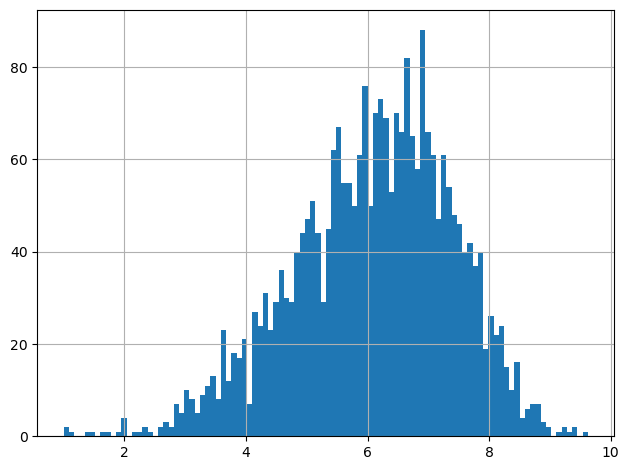

In [7]:


df.mean_rating.hist(bins=100)  # Set the figure size (width, height)
plt.tight_layout()  # Adjust the layout to prevent overlap of axes labels
plt.show() 

In [8]:
df.describe()

,mean_rating
count,2607.000000
mean,6.091081
std,1.313008
min,1.000000
25%,5.223801
50%,6.222222
75%,7.029889
max,9.625000


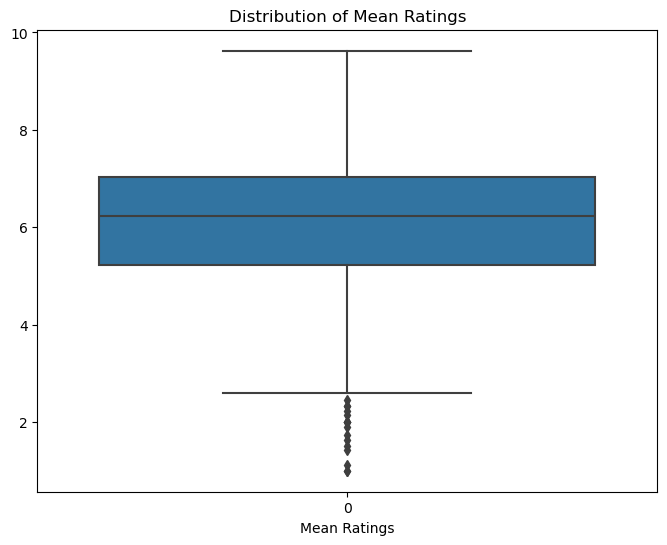

In [9]:
# Create a box plot for the distribution of mean ratings
plt.figure(figsize=(8, 6))  # Set the figure size (width, height)
sns.boxplot(data=df.mean_rating)  # Plot the box plot for the 'mean' column
plt.title('Distribution of Mean Ratings')  # Set the title of the plot
plt.xlabel('Mean Ratings')  # Set the label for the x-axis
plt.show()

It looks like a bell curve centered around 6.2 with a standard deviation of 1.31. The lower tail looks fatter. We keep this observation in mind and will later test for normality as hypothesis 1.
 
### Distribution by gender 

Now let's see if there is any difference between genders and between ethnicity

In [10]:
 df.groupby('gender').mean_rating.describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
female,1354.0,6.578896,1.250745,1.117647,5.888889,6.777778,7.466071,9.625000
male,1199.0,5.554681,1.153528,1.000000,4.824085,5.633987,6.400781,9.333333


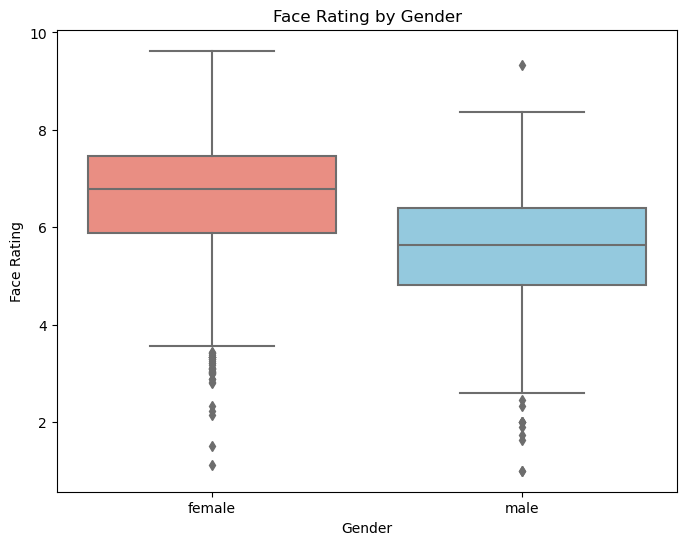

In [11]:
# Box plot of face ratings by gender

custom_palette = {'male': 'skyblue', 'female': 'salmon'}

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='gender', y='mean_rating', palette=custom_palette)
plt.title('Face Rating by Gender')
plt.xlabel('Gender')
plt.ylabel('Face Rating')
plt.show()

Here are a few takeaways from those plots : 
  - The shape of the two distributions look roughly similar to each others (bell-curved) and also to the combined distribution. The female ratings seem slightly more skewed to the left. But the sample size for females is slightly bigger.
  -  On average, women seem to be deemed more attractive than men (with a difference between the medians 6.7-5.6 = 1.1 point). This could be due to the gender of the raters as well as their sexual orientation. Unfortunately we don't have access to those informations. We will test this hypothesis more rigourously later as hypothesis 2.

### Distribution by ethnicity

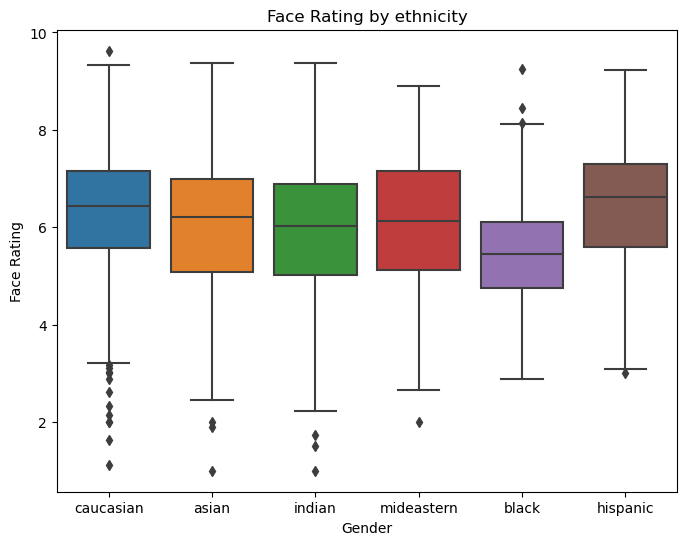

In [12]:
# Box plot of face ratings by gender (example)
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='ethnicity', y='mean_rating')
plt.title('Face Rating by ethnicity')
plt.xlabel('Gender')
plt.ylabel('Face Rating')
plt.show()

In [13]:
 df.groupby('ethnicity').mean_rating.describe()

,count,mean,std,min,25%,50%,75%,max
ethnicity,,,,,,,,
asian,354.0,6.009059,1.410367,1.000000,5.090000,6.216374,7.000000,9.375000
black,299.0,5.436257,1.118016,2.875000,4.760965,5.444444,6.111111,9.250000
caucasian,999.0,6.297266,1.217886,1.117647,5.571429,6.444444,7.145503,9.625000
hispanic,300.0,6.447883,1.169024,3.000000,5.599781,6.626549,7.298203,9.222222
indian,304.0,5.892545,1.403382,1.000000,5.025426,6.030556,6.895833,9.375000
mideastern,297.0,6.055797,1.416537,2.000000,5.115385,6.130081,7.148148,8.909091


We notice a few interesting things : 
- Most categories are balanced (about 300), except caucasian which is much more frequent (999)
- There seems to be significant variation of average rating between each ethnicity. Hispanic is the ethnicity rated as highest on average and black as the lowest. We will test this most throughsly later as Hypothesis 3 and 4.
- Asian, indian and middle-eastern ethnicities have a higher standard deviation (>1.4) than other ethnicities(1.16-1.21)
- Excluding outliers, the range of the black distribution is condiderably smaller than other distributions. Indian ethnicity on the opposite appears to have the highest range. This is coherent with the previous observation about standard deviations.
- Most ethnicities's distribution looks roughly symetric except for asian and hispanic ethnicities which appear left-skewed.

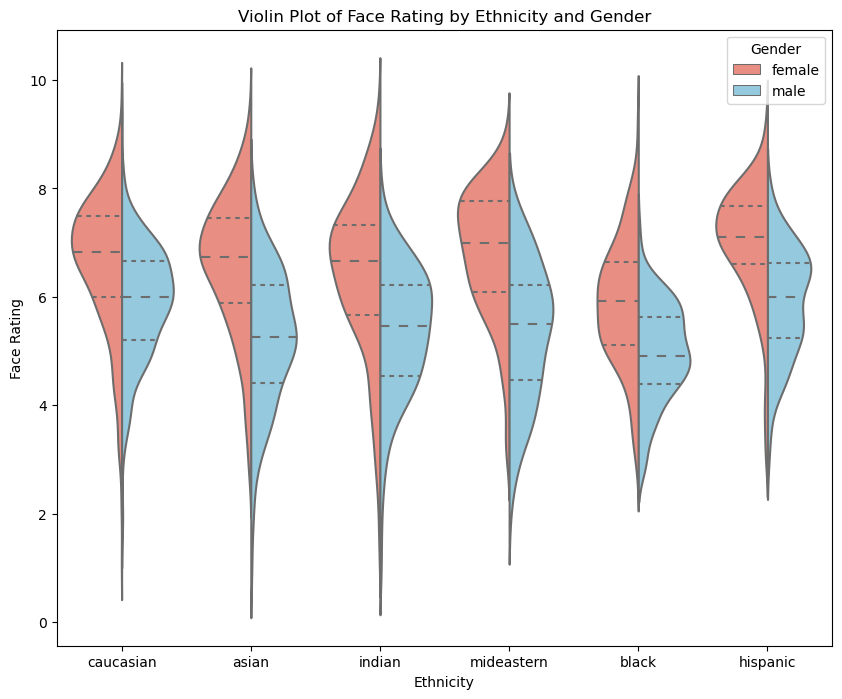

In [14]:
#Now let's put it all together ! 
# Violin plot of face ratings by gender and ethnicity
plt.figure(figsize=(10, 8))  # Set the figure size (width, height)
sns.violinplot(data=df, x='ethnicity', y='mean_rating', hue='gender', split=True, palette=custom_palette, inner="quart")
plt.title('Violin Plot of Face Rating by Ethnicity and Gender')  # Set the title of the plot
plt.xlabel('Ethnicity')  # Set the label for the x-axis
plt.ylabel('Face Rating')  # Set the label for the y-axis
plt.legend(title='Gender')  # Add a legend with title for the 'gender' hue
plt.show()

In [15]:
 df.groupby(['gender', 'ethnicity']).mean_rating.describe()

count      mean       std       min       25%       50%  \
gender ethnicity                                                             
female asian       202.0  6.597741  1.227623  2.793333  5.889881  6.740741   
       black       151.0  5.893818  1.134123  2.884615  5.111111  5.920000   
       caucasian   551.0  6.629904  1.238159  1.117647  6.000000  6.833333   
       hispanic    151.0  6.999209  1.060515  3.090909  6.601852  7.111111   
       indian      152.0  6.421842  1.415463  1.500000  5.663793  6.666667   
       mideastern  147.0  6.796170  1.160364  3.111111  6.081897  7.000000   
male   asian       152.0  5.226732  1.250732  1.000000  4.420015  5.259552   
       black       148.0  4.969421  0.887115  2.875000  4.398430  4.915923   
       caucasian   448.0  5.888151  1.058849  1.625000  5.198533  6.000000   
       hispanic    149.0  5.889157  0.998318  3.000000  5.235507  6.000000   
       indian      152.0  5.363248  1.176626  1.000000  4.551120  5.468856   
       mideastern  150.0  5.330232  1.263374  2.000000  4.466139  5.509804   

                        75%       max  
gender ethnicity                       
female asian       7.458333  9.375000  
       black       6.636364  9.250000  
       caucasian   7.500000  9.625000  
       hispanic    7.681548  9.222222  
       indian      7.333333  9.375000  
       mideastern  7.763889  8.909091  
male   asian       6.222222  8.000000  
       black       5.631250  7.250000  
       caucasian   6.666667  9.333333  
       hispanic    6.629167  8.000000  
       indian      6.217320  7.888889  
       mideastern  6.224306  7.727273

Here are some takeaways from those plots : 
- For all ethnicities, women are deemed more attractive on average. There is at least a quartile of difference between both genders for each ethnicity.
- for the female distributions, all ethnicities have a longer left tail, except for black women. This seems less pronounced for men
- Comparing the male and female distribution for each ethnicity, we notice that
- - for hispanic they are the most far apart (with Q1 of female about equal to Q3 of male). The very high mean rating of hispanic faces can be explained by the very high mean rating of female hispanic faces
  -  for caucasian they are the closest (with Q1 of of female equal to Q2 of male)



## Testing Hypotheses about mean ratings

First, let's recall the hypotheses we are interested in testing : 
1. The mean ratings come from a normal distribution
2. the mean of the mean ratings of women is higher than the mean of mean ratings of men
3. the mean of the mean ratings of hispanic faces is higher than the means of other ethnicities 
4. the mean of the mean ratings of black faces is lower than the means of other ethnicities 

We will perform several statistical tests to see if the data allow us to confidently reject nul hypothesis. We will set a significance level α=5% .


In [16]:
alpha = 0.05


### 1. Normal distribution

We set the following hypothesis :
- H0 : The mean ratings come from a normal distribution
- H1: the mean ratings do not come from a normal distribution


First, let-s make a QQ-Plot to see more precisely how close our sample distribution is to the normal distribution.


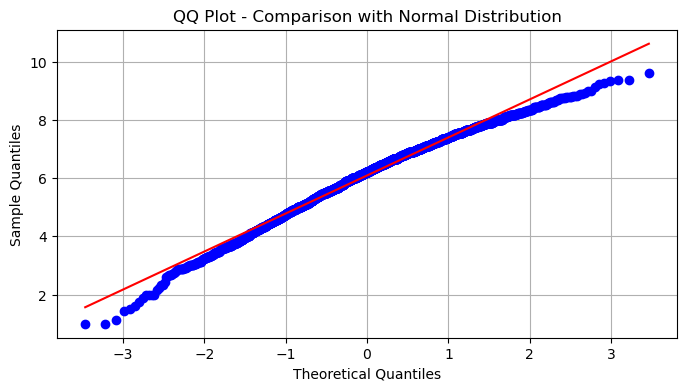

In [17]:
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import probplot

# Create QQ plot
plt.figure(figsize=(8, 4))
probplot(df.mean_rating, dist="norm", plot=plt)
plt.title('QQ Plot - Comparison with Normal Distribution')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()


Looks very close in the center of the distribution but both tails are below the normal (red) line, which indicates a left-skewness compared to the normal distribution as we already suspected based on the histogram and boxplot. Now let's see if we can conclude normality nonetheless based on quantitative tests.

In [18]:
stat, p_value = shapiro(df.mean_rating)
stat, p_value
if p_value < 0.05:
    print("The data is not normally distributed (reject null hypothesis)")
else:
    print("The data is normally distributed (fail to reject null hypothesis)")
stat, p_value

The data is not normally distributed (reject null hypothesis)


(0.9874439835548401, 2.1159794429863668e-14)

Using Shapiro-Wilk's test, we get a p-value close to 0, which is clearly lower than our significance level (0.05). Thus we reject the null hypothesis and conclude that our data does not come from a normal distribution. 
As a sanity check, let's use Person's test for normality.

In [19]:

statistic, p_value = normaltest(df.mean_rating)

# Interpret the test result
alpha = 0.05
print(f"Normality Test - Statistic: {statistic:.4f}, p-value: {p_value:.4f}")
if p_value < alpha:
    print("The data does not follow a normal distribution (reject null hypothesis)")
else:
    print("The data follows a normal distribution (fail to reject null hypothesis)")


Normality Test - Statistic: 78.7098, p-value: 0.0000
The data does not follow a normal distribution (reject null hypothesis)


Again, we find that our data is not normally distributed. However, based on the QQ-plot, we have observed a left-skewkess. Let's estimate it : 

In [20]:
from scipy.stats import skew

# Calculate skewness of the data
data_skewness = skew(df.mean_rating)
print(f"Skewness of Data: {data_skewness:.2f}")


Skewness of Data: -0.44


Our data is moderately skewed. We will use boostrapping  to estimate the mean and compute a percentile-based confidence interval, which is robust against skewness and non-normality.

In [21]:
import numpy as np
from sklearn.utils import resample

# Perform bootstrap resampling to estimate mean and confidence interval
bootstrap_means = []
num_iterations = 1000  # number of bootstrap iterations
for _ in range(num_iterations):
    sample = resample(df.mean_rating)
    bootstrap_means.append(np.mean(sample))

# Compute confidence interval (e.g., 95%)
confidence_interval = np.percentile(bootstrap_means, [2.5, 97.5])
print(f"Bootstrap Mean (95% Confidence Interval): {np.mean(bootstrap_means):.2f} ± {np.diff(confidence_interval)[0]:.2f}")


Bootstrap Mean (95% Confidence Interval): 6.09 ± 0.10


In [22]:
df.mean_rating.describe()

count    2607.000000
mean        6.091081
std         1.313008
min         1.000000
25%         5.223801
50%         6.222222
75%         7.029889
max         9.625000
Name: mean_rating, dtype: float64

The boostrapped mean is equal to the sample mean ! The median is slightly higher than the mean, which is characteristic of left skewness.

### Male ratings VS female ratings

We are out to show that female faces are on average rated higher than male faces. 

- H0 : 2. the mean of the mean ratings of women is higher than the mean of mean ratings of men
- H1 : the mean of the mean ratings of women is higher than the mean of mean ratings of men

As we saw above, our data is not normally distributed. However, the distribution is not that far off from the normal distribution (it is simply left-skewed) AND we have a large sample-size. Thus, thanks to central limit theorem, we may still assume that the means will approximately follow a normal distribution. To be cautious however, we will assume a student-t distribution (we don't know the true standard deviation) . 

To compare the two independent groups (male vs female faces) we perform a two-sample t-test. There is no reason to think the variances of the groups are equal so Welch's test is appropriate. The degree of freedom will be computed based on the sample size (male n = 1199 and female n = 1354)

In [23]:
df.groupby("gender").describe()

mean_rating                                                    \
             count      mean       std       min       25%       50%   
gender                                                                 
female      1354.0  6.578896  1.250745  1.117647  5.888889  6.777778   
male        1199.0  5.554681  1.153528  1.000000  4.824085  5.633987   

                            
             75%       max  
gender                      
female  7.466071  9.625000  
male    6.400781  9.333333

In [24]:
from scipy.stats import ttest_ind

# Separate data for female and male faces (replace with your dataset and column names)
female_ratings = df[df['gender'] == 'female']['mean_rating']
male_ratings = df[df['gender'] == 'male']['mean_rating']

# Perform two-sample t-test assuming unequal variances (Welch's t-test)
test_statistic, p_value = ttest_ind(female_ratings, male_ratings, equal_var=False)

# Print test results
print(f"Test Statistic: {test_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the test results

if p_value < alpha:
    print("Reject the null hypothesis (H0): The mean of female ratings is significantly higher than male ratings.")
else:
    print("Fail to reject the null hypothesis (H0): There is no significant difference in mean ratings between female and male faces.")


Test Statistic: 21.5200
P-value: 0.0000
Reject the null hypothesis (H0): The mean of female ratings is significantly higher than male ratings.


### Rating of Hispanic faces VS other ethnicities
Now we want to find whether hispanic faces are really rated higher than other ethnicities: 

- H0: The mean ratings of Hispanic faces are not significantly different from the mean ratings of other ethnicities combined.- (H): The mean ratings of Hispanic faces are higher than the mean ratings of other ethnicities combined.

To do this we can perform an ANOVA. It will allow us to compare the means of the different ethnicities to determine if there are statistically significant differences among them.

In [25]:
from scipy.stats import f_oneway

# Separate data for Hispanic faces and other ethnicities (replace with your dataset and column names)
hispanic_ratings = df[df['ethnicity'] == 'hispanic']['mean_rating']
other_ethnicities_ratings = df[df['ethnicity'] != 'hispanic']['mean_rating']

# Perform one-way ANOVA test
test_statistic, p_value = f_oneway(hispanic_ratings, other_ethnicities_ratings)

# Print test results
print(f"One-way ANOVA Test Statistic: {test_statistic:.4f}")
print(f"P-value: {p_value:}")

# Interpret the test results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis (H0): There is a significant difference in mean ratings between Hispanic faces and other ethnicities.")
else:
    print("Fail to reject the null hypothesis (H0): There is no significant difference in mean ratings between Hispanic faces and other ethnicities.")


One-way ANOVA Test Statistic: 25.2674
P-value: 5.329292507290379e-07
Reject the null hypothesis (H0): There is a significant difference in mean ratings between Hispanic faces and other ethnicities.


### Rating of Hispanic faces VS other ethnicities

Similariy we want to see if the mean rating of black faces is significantly lower than tthe mean ratings of other ethnicities


- H0: The mean ratings of Black faces are not significantly different from the mean ratings of other ethnicities combined.
- H1: The mean ratings of Black faces are higher than the mean ratings of other ethnicities combined.


In [26]:
from scipy.stats import f_oneway

# Separate data for Hispanic faces and other ethnicities (replace with your dataset and column names)
hispanic_ratings = df[df['ethnicity'] == 'black']['mean_rating']
other_ethnicities_ratings = df[df['ethnicity'] != 'black']['mean_rating']

# Perform one-way ANOVA test
test_statistic, p_value = f_oneway(hispanic_ratings, other_ethnicities_ratings)

# Print test results
print(f"One-way ANOVA Test Statistic: {test_statistic:.4f}")
print(f"P-value: {p_value:}")

# Interpret the test results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis (H0): There is a significant difference in mean ratings between Hispanic faces and other ethnicities.")
else:
    print("Fail to reject the null hypothesis (H0): There is no significant difference in mean ratings between Hispanic faces and other ethnicities.")


One-way ANOVA Test Statistic: 86.7669
P-value: 2.516244858913071e-20
Reject the null hypothesis (H0): There is a significant difference in mean ratings between Hispanic faces and other ethnicities.


In [27]:
from scipy.stats import f_oneway

# Separate data for Hispanic faces and other ethnicities (replace with your dataset and column names)
hispanic_ratings = df[df['ethnicity'] == 'indian']['mean_rating']
other_ethnicities_ratings = df[df['ethnicity'] != 'indian']['mean_rating']

# Perform one-way ANOVA test
test_statistic, p_value = f_oneway(hispanic_ratings, other_ethnicities_ratings)

# Print test results
print(f"One-way ANOVA Test Statistic: {test_statistic:.4f}")
print(f"P-value: {p_value:}")

# Interpret the test results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis (H0): There is a significant difference in mean ratings between Hispanic faces and other ethnicities.")
else:
    print("Fail to reject the null hypothesis (H0): There is no significant difference in mean ratings between Hispanic faces and other ethnicities.")


One-way ANOVA Test Statistic: 7.8888
P-value: 0.005011338950246992
Reject the null hypothesis (H0): There is a significant difference in mean ratings between Hispanic faces and other ethnicities.


## Individual ratings
### distribution of ratings by rater
So far we have explored and tested the mean ratings given to each picture. Those mean ratings are the means facial rating done by each individual rater. We are now interesting in analysing those individual ratings. We use the dataframe that we set aside. First problem : we have many missing values

In [43]:
df = complete_df.copy()
df.iloc[: ,1:-2].count(axis=1) /  df.shape[1] 

0       0.044077
1       0.013774
2       0.022039
3       0.019284
4       0.022039
          ...   
2602    0.024793
2603    0.022039
2604    0.022039
2605    0.022039
2606    0.022039
Length: 2607, dtype: float64

Most values (more than 99% in each row) are missing. To deal with this, we reshape your dataset from wide format (one column per rater) to long format (one column for ratings and one column for rater identifiers and one column for image identifier).

In [44]:

df.reset_index(inplace=True)
# Rename the index column to 'image' 
df_individual_ratings = df.rename(columns={'index': 'image'}).drop(["mean_rating", "gender", "ethnicity"], axis=1)

# Convert dataframe to long format (Image as index, Rater as a variable, Rating as values)
ratings_long = pd.melt(df_individual_ratings, id_vars='image', var_name='rater', value_name='rating')
ratings_long.dropna(inplace = True)

In [45]:
ratings_long

,image,rater,rating
3,3,rater_1,1.0
12,12,rater_1,1.0
16,16,rater_1,1.0
17,17,rater_1,1.0
18,18,rater_1,1.0
...,...,...,...
938005,2092,rater_360,8.0
938084,2171,rater_360,8.0
938090,2177,rater_360,9.0
938339,2426,rater_360,9.0


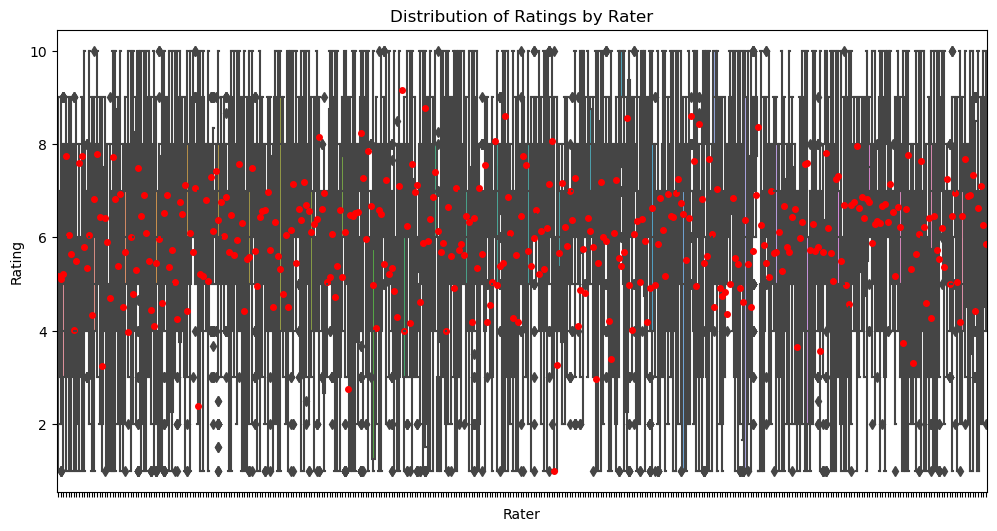

In [31]:
#Use violin plot for visualizing rater variability
plt.figure(figsize=(12, 6))
sns.boxplot(x='rater', y='rating', data=ratings_long)

# Customize x-axis ticks (show ticks without labels)
num_raters = len(ratings_long['rater'].unique())
plt.xticks(ticks=range(num_raters), labels=['']*num_raters)  # Empty labels for ticks

rater_mean_ratings = ratings_long.groupby('rater')['rating'].mean().reset_index()
for i, mean_rating in enumerate(rater_mean_ratings['rating']):
    plt.plot(i, mean_rating, 'ro', markersize=4)  # Red circle marker for mean


plt.title('Distribution of Ratings by Rater')
plt.xlabel('Rater')
plt.ylabel('Rating')
plt.show()


At first sight, we see that there is a lot of variation in the way raters rate. The range of values is very large for some raters and narrow for others. Likewise the mean value (red points) can go from very low (as low as 1!) to very high (as high as 9!). This is all very hard to see since there is a lot of values. Let's have a look at the distribution of some distribution statistics of the raters : mean, minimum, maximum and standard deviation.

Caveat : the rated images are not the same for each rater. So, although the variation may depend on the rater, it may also be attributed (for a non negligeable part) to the fact that the faces being rated are different . Especially considering that the sample size of rated images for each rater is quite low (24 on average). Also, the sample size is not the same for each image.

D:\Utilisateurs\souma\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


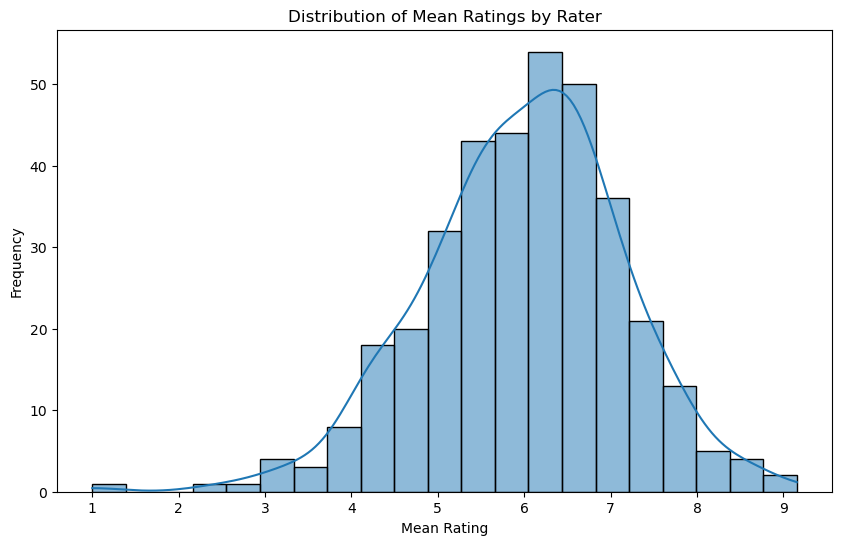

,rating
count,360.000000
mean,5.978030
std,1.145864
min,1.000000
25%,5.312547
50%,6.070016
75%,6.704198
max,9.154167


In [32]:
# Plot distribution of mean ratings for each rater
rater_mean_ratings = ratings_long.groupby('rater')['rating'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.histplot(rater_mean_ratings['rating'], kde=True)
plt.title('Distribution of Mean Ratings by Rater')
plt.xlabel('Mean Rating')
plt.ylabel('Frequency')
plt.show()
rater_mean_ratings.describe()

The distribution of mean ratings for each look approximately normal. That is, the number of  lenient raters vs harsh raters seems quite balanced and centered around 6. We will keep normality and related mean and standard deviation as #H6.

In [33]:

mean_ratings = ratings_long.groupby('rater')['rating'].mean()
# Perform Shapiro-Wilk test for normality
stat, p_value = shapiro(mean_ratings)

# Interpret the test result
print(stat, p_value)
if p_value > alpha:
    print("Mean ratings by rater are normally distributed (Fail to reject H0)")
else:
    print("Mean ratings by rater are not normally distributed (Reject H0)")

0.9897834062576294 0.013021747581660748
Mean ratings by rater are not normally distributed (Reject H0)


In [34]:
from scipy.stats import jarque_bera

# Extract mean ratings for each rater
mean_ratings = ratings_long.groupby('rater')['rating'].mean()

# Perform Jarque-Bera test for normality
stat, p_value = jarque_bera(mean_ratings)

# Interpret the test result
alpha = 0.05
if p_value > alpha:
    print("Mean ratings by rater are normally distributed (Fail to reject H0)")
else:
    print("Mean ratings by rater are not normally distributed (Reject H0)")


Mean ratings by rater are not normally distributed (Reject H0)


### Inter-rater variation in rating
We want to analyse the variation of the ratings within each image. A first issue is that since the raters have each rated different images (even if there is some overlap), each image is associated with a different number of rating. Let's have a look at the distribution of the "sample size" of each individual image.

D:\Utilisateurs\souma\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


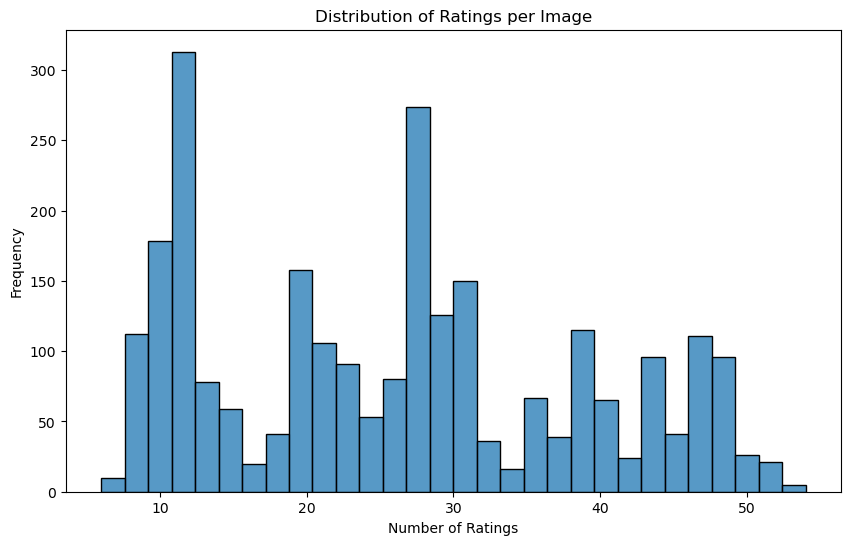

In [46]:
df = complete_df.iloc[:, 1:] #only keep the individual ratings
# Plot distribution of ratings per image
plt.figure(figsize=(10, 6))
sns.histplot(df.count(axis=1), bins=30)
plt.title('Distribution of Ratings per Image')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()


We see that there is a lot of variation ! Some images have as high as 50 ratings while others have less than 10. Since we have a lot of images in total, we will keep only the images with a lot of ratings. As a matter of fact, since we want to highlight the variability in ratings for each image, a high number of ratings should be the priority in our choice of data. We will set the lower threshold as"25" to ensure a sufficient number of samples while preserving more than half of the dataset.

In [60]:
# Set thresholds for minimum and maximum number of ratings per image
min_ratings_threshold = 25

# Filter images based on number of ratings within the specified range
filtered_ratings = df[df.count(axis=1, numeric_only=True)>= min_ratings_threshold]

# Calculate percentage of images retained
percentage_retained = len(filtered_ratings) / len(df) * 100
print(f"Percentage of Images Retained: {percentage_retained:.2f}%")
print(f"Number of Images Retained: {len(filtered_ratings)}")
# Filter dataframe to retain images within the specified range of ratings
filtered_df = df.loc[filtered_ratings.index]


Percentage of Images Retained: 50.17%
Number of Images Retained: 1308


D:\Utilisateurs\souma\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


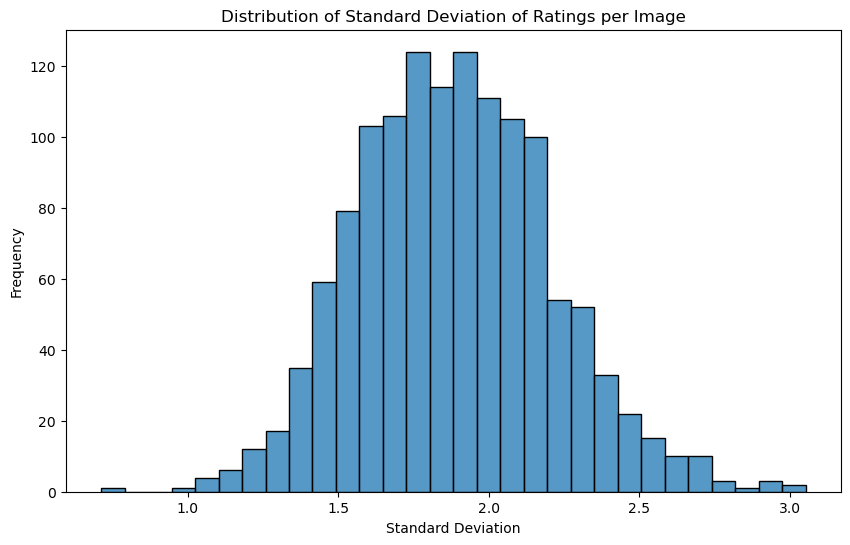

count    1306.000000
mean        1.886752
std         0.321638
min         0.712125
25%         1.655470
50%         1.877746
75%         2.101505
max         3.053098
dtype: float64

In [56]:
image_standard_deviations = filtered_df.std(axis=1, numeric_only=True)
image_means = filtered_df.mean(axis=1, numeric_only=True)
# Plot distribution of standard deviation
plt.figure(figsize=(10, 6))
sns.histplot(image_standard_deviations, bins=30)
plt.title('Distribution of Standard Deviation of Ratings per Image')
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')
plt.show()
image_standard_deviations.describe()

Based on the distribution of standard deviations we find that on average, the images have a standard deviations of 1.88 . This standard deviation provides a measure of the typical amount of variation or dispersion of ratings around the mean rating for each image. The standard deviation is quite low (0.32), which means that most images have a similar inter-rating variation (close to 1.88), which indicates that the most faces are subject to a similar amount of subjective assessment.
It can be interesting to check whether there is a correlation between the mean rating of the image and the standard deviation of each rating. units of the mean rating.

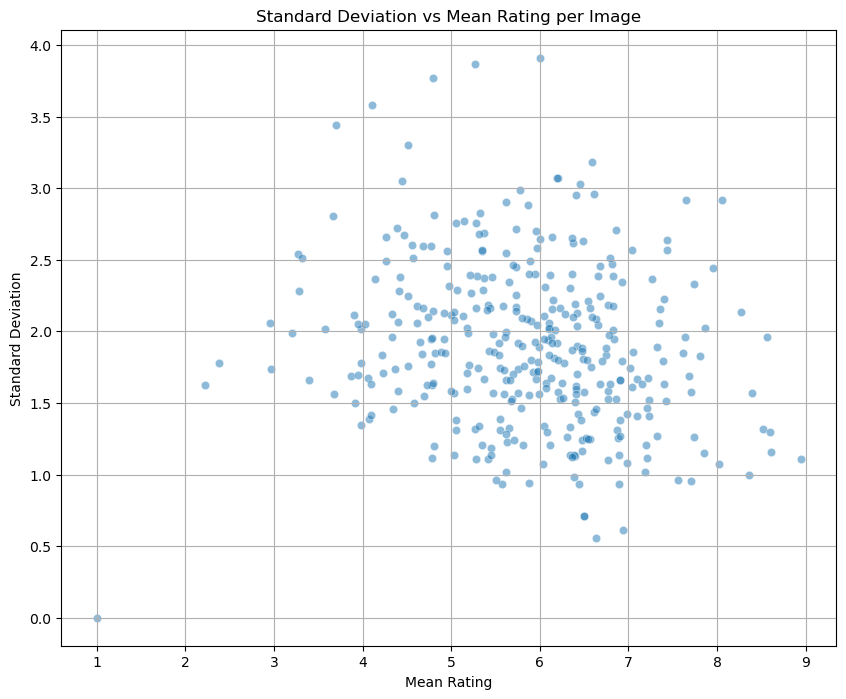

Correlation between Std Deviation and Mean Rating: -0.17


In [66]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(image_means, image_standard_deviations)

# Plotting standard deviation (y-axis) vs mean rating (x-axis)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=image_means, y=image_standard_deviations, alpha=0.5)
plt.title('Standard Deviation vs Mean Rating per Image')
plt.xlabel('Mean Rating')
plt.ylabel('Standard Deviation')
plt.grid(True)
plt.show()


# Calculate correlation between standard deviation and mean rating
correlation = filtered_df.std().corr(filtered_df.mean())
print(f"Correlation between Std Deviation and Mean Rating: {correlation:.2f}")


We find a correlation coefficient of -0.17: Images with higher mean ratings (considered more attractive on average) tend to have more consistent ratings among raters, showing a degree of consensus. Conversely, images with lower mean ratings exhibit greater variability in ratings, reflecting diverse opinions among raters.. In other words, depending on how attractive someone is, the more consensus there is. We need to keep in mind that the correlation coefficient is still relatively weak, althought the tendency is visible in the scatterplot.

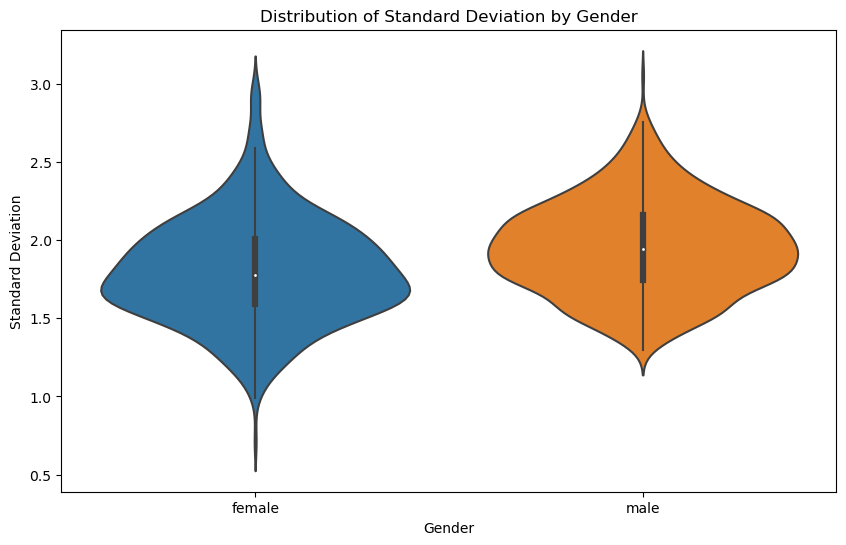

In [62]:
# Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=filtered_df, x='gender', y=image_standard_deviations)
plt.title('Distribution of Standard Deviation by Gender')
plt.xlabel('Gender')
plt.ylabel('Standard Deviation')
plt.show()

There is a higher variation in the ratings of the male faces than rating the female faces. This goes hand in hand with the observation that generally more attractive faces are more consensual and the fact that women are generally deemed more attractive than men.

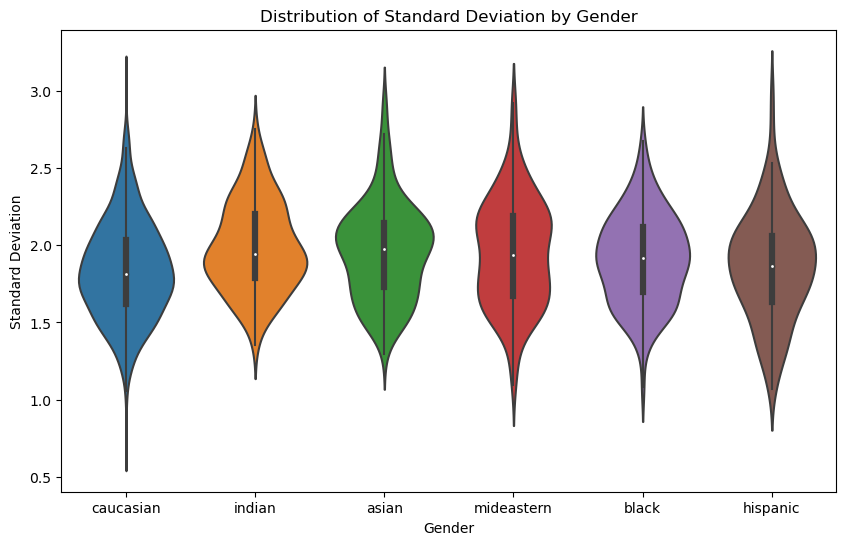

In [63]:
# Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=filtered_df, x='ethnicity', y=image_standard_deviations)
plt.title('Distribution of Standard Deviation by Gender')
plt.xlabel('Gender')
plt.ylabel('Standard Deviation')
plt.show()

Caucasian appears to be the most consensual ethnicity while asian is the least consensual.

Given the scenario where each image has been rated by different subsets of raters, with potential overlap of raters across images, you can leverage statistical methods that accommodate the varying and overlapping nature of raters across images to measure inter-rater agreement effectively. One approach is to use a multilevel modeling framework, such as a mixed-effects model or hierarchical model, to estimate inter-rater reliability while accounting for the nested structure of your data (ratings nested within images and raters).

In [ ]:

import statsmodels.api as sm
import statsmodels.formula.api as smf



In [ ]:
# Fit a mixed-effects model (random intercepts for Rater and Image)
model = smf.mixedlm("rating ~ 1", data=ratings_long, groups=ratings_long["rater"], re_formula="1")
result = model.fit()

# Display model summary to examine inter-rater agreement estimates
print(result.summary())


Assessment of Inter-Rater Agreement:
The Group Var provides insights into the extent of disagreement or variability in ratings among different raters.
Higher values of Group Var indicate lower inter-rater agreement, as more variability in ratings can be attributed to differences between raters.
Conversely, lower values of Group Var suggest higher inter-rater agreement, as less variability in ratings is explained by differences between raters.
Statistical Significance:
Both the intercept (Intercept) and the Group Var are statistically significant (P < 0.0001), indicating that the differences in ratings between raters are unlikely to be due to random ch

Based on the output provided, the estimated Group Var (1.261) indicates that there is significant variability in ratings across different raters, implying lower inter-rater agreement. Further analysis and exploration may be needed to understand the factors contributing to this variability and to assess the reliability and consistency of ratings among the raters.ance.